# Accent classification with average pooling

In [102]:
DEV = True
EPOCHS = 2

DEBUG = False
FAKE_DATA = False

In [103]:
# autoreloads
%reload_ext autoreload
%autoreload 1
%aimport parameters

# Allows to load modules from parent directory
from time import time
import inspect, sys
from os.path import dirname, abspath
sys.path.append(dirname(dirname(abspath(inspect.getfile(inspect.currentframe())))))

from pathlib import Path
from os import makedirs

#from models.accent_classifier import AccentClassifier

from tqdm import tqdm_notebook as tqdm

from torch.nn.modules import CrossEntropyLoss
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_

import numpy as np
import pandas as pd

from data.data_loader import create_binarizer, get_accents_counts
from data.data_loader import SpectrogramAccentDataset, BucketingSampler, AudioDataLoader
from utils import count_parameters, Timer

from tensorboardX import SummaryWriter

In [104]:
samples = []
import math
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable

from models.modules import MaskConv, SequenceWise, BatchRNN, InferenceBatchSoftmax, \
                    supported_rnns, supported_rnns_inv

class AccentClassifier(nn.Module):
    def __init__(self,
                 labels,
                 audio_conf, 
                 hidden_size,
                 rnn_type=nn.GRU,
                 DEBUG = False, 
                 clip=700):
        
        super(AccentClassifier, self).__init__()
        
        self._DEBUG = DEBUG

        # metadata
        self._audio_conf = audio_conf
        self._labels = labels
        self._num_classes = len(labels)
        self._clip = clip
        self._hidden_size = hidden_size
        
        sample_rate = self._audio_conf.get("sample_rate", 16000)
        window_size = self._audio_conf.get("window_size", 0.02)

        self.rnn = rnn_type(self._clip, self._hidden_size, 2, bidirectional=True, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(self._hidden_size * 2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, self._num_classes),
            nn.ReLU(),
        )
        
        self.avgpool = nn.AvgPool1d(161)
        
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, lengths):
        if self._DEBUG:
            print('Start forward')
            print('x size:', x.size())
            
        # Remove channel
        x = x.view(x.size(0), x.size(2), x.size(3))
        
        if self._DEBUG:
            print('after view:', x.size())
            
        if x.size(2) >= self._clip:
            x = x[:, :, :self._clip].contiguous()
        else:
            z = torch.zeros(torch.Size((x.size(0), x.size(1), self._clip - x.size(2))))
            z = z.cuda() if x.is_cuda else z
            if self._DEBUG:
                print('_cat x:', x.size())
                print('_cat z:', z.size())
            x = torch.cat((x, z), 2)
        
        if self._DEBUG:  
            print('after clip:', x.size())
            
        x, __ = self.rnn(x)
        
        if self._DEBUG:
            print('after rnn:', x.size())
            
        x = self.fc(x)
        
        if self._DEBUG:
            print('after fully co:', x.size())
            
#         x = x.transpose(1, 2)
#         x = self.avgpool(x)
#         x = x.transpose(1, 2)
        x = torch.mean(x, dim=1)
        
        if self._DEBUG:
            print('after avg pooling:', x.size())
            
        x = self.sigmoid(x)
            
        if self._DEBUG:
            print('after sigmoid:', x.size())
            
        #x = x.view(x.size(0), x.size(2))
        
        if self._DEBUG:
            print('after view:', x.size())
            print('output:', x)
            
        return x

## Utilities

In [105]:
# Configure experiments by directly changing the values in parameters.py
param = parameters.get_parameters(dev=DEV, epochs=EPOCHS)

In [106]:
import time
def now():
    localtime   = time.localtime()
    timeString  = time.strftime("%Y-%m-%d_%Hh%M:%S", localtime)
    return timeString

In [107]:
# Tensorboard
exp_name = f'__tmp__{now()}'
tb_path = Path(param['tensorboard_dir']) / exp_name
makedirs(tb_path, exist_ok=True)
tb_writer = SummaryWriter(tb_path)

In [108]:
def process_data(data):
    inputs, targets, input_percentages, target_sizes, target_accents = data
    if len(target_accents[0]) > 1:
        target_accents = np.argmax(target_accents, axis=1)
    #else:
        #target_accents = target_accents.view(target_accents.size(0))
    target_accents = target_accents.view(target_accents.size(0))
        
    if param['cuda']:
        inputs = inputs.cuda()
        target_accents = target_accents.cuda()
    
    input_sizes = input_percentages.mul_(int(inputs.size(3))).int()     
    
    
    if FAKE_DATA:
        inputs = torch.rand_like(inputs)
        for i, t in enumerate(target_accents):
            adj = (t.item() - 0.5) * 0.8
            inputs[i] = inputs[i] + adj
            if input_sizes[i] < inputs[i].size(2):
                z = torch.zeros(torch.Size((inputs[i].size(0), inputs[i].size(1), inputs[i].size(2) - input_sizes[i])))
                z = z.cuda() if inputs.is_cuda else z
                inputs[i] = torch.cat((inputs[i][:, :, :input_sizes[i]], z), 2)
        
        
    return inputs, target_accents, input_sizes

## Data Loading

In [109]:
audio_conf = {'sample_rate': param['sample_rate'],
                'window_size': param['window_size'],
                'window_stride': param['window_stride'],
                'window': param['window'],
                'noise_dir': param['noise_dir'],
                'noise_prob': param['noise_prob'],
                'noise_levels': (param['noise_min'], param['noise_max'])}

In [110]:
accent_binarizer = create_binarizer(param['train_manifest'])
labels = accent_binarizer.classes_

In [111]:
train_dataset = SpectrogramAccentDataset(audio_conf=audio_conf, 
                                        manifest_filepath=param['train_manifest'], 
                                        labels=labels,
                                        normalize=True, 
                                        augment=param['augment'], 
                                        accent_binarizer=accent_binarizer,
                                        kaldi=False)

train_sampler = BucketingSampler(train_dataset, batch_size=param['batch_size'])

train_loader = AudioDataLoader(train_dataset,
                                num_workers=param['num_worker'], 
                                batch_sampler=train_sampler)

In [112]:
test_dataset = SpectrogramAccentDataset(audio_conf=audio_conf, 
                                        manifest_filepath=param['test_manifest'], 
                                        labels=labels,
                                        normalize=True, 
                                        augment=False, 
                                        accent_binarizer=accent_binarizer,
                                        kaldi=False)

test_loader = AudioDataLoader(test_dataset,
                                num_workers=param['num_worker'], 
                                batch_size=param['batch_size'])

## Model initialization

In [116]:
# train_counts = get_accents_counts(param['train_manifest'])
# class_counts = [train_counts[c] / max(train_counts.values()) for c in accent_binarizer.classes_]
# weights = 1 / torch.tensor(class_counts)
# weights = torch.tensor([1. for __ in weights])

In [114]:
model = AccentClassifier(labels=labels, 
                         audio_conf=audio_conf, 
                         hidden_size=param['rnn_hidden_size'],  
                         rnn_type=param['rnn_type'], 
                         DEBUG=DEBUG)
if param['cuda']:
    model.cuda()
    weights = weights.cuda()
    
criterion = CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=param['lr'][0])

print(model)
print('Model parameters counts:', count_parameters(model))

AccentClassifier(
  (rnn): GRU(700, 800, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=1600, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
    (5): ReLU()
  )
  (avgpool): AvgPool1d(kernel_size=(161,), stride=(161,), padding=(0,))
  (sigmoid): Sigmoid()
)
Model parameters counts: 20904450


## Training

In [115]:
SILENT = True
    
t = Timer()

best_model = None
prev_acc = 0
## Train
for epoch in range(1, param['epochs'] + 1):
    print(f'\n## EPOCH {epoch} ##')
    print(f'Training:')
    model.train()

    # train
    epoch_losses = []
    t.add(f'EPOCH {epoch}')
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        t.add('Start loop')
        inputs, target_accents, input_sizes = process_data(data)
        
        # Forward pass
        t.add('Process data')
        out = model(inputs, input_sizes)
        t.add('Forward')
        
        
#         new_out = out.view(out.size(0) * out.size(1), out.size(2))
#         new_tar = target_accents.view(target_accents.size(0), 1).expand(target_accents.size(0), 161).contiguous()
#         new_tar = new_tar.view(-1)
#         loss = criterion(new_out, new_tar)
        
        loss = criterion(out, target_accents)
        t.add('Criterion')
        epoch_losses.append(loss)
        
        if not SILENT:
            print(f'Iteration {i+1}/{len(train_loader):<4}loss: {loss:0.3f}')
        
        # Gradient
        optimizer.zero_grad()
        loss.backward()
        t.add('Backward')
        
        #clip_grad_norm_(model.parameters(), param['max_norm'])
        optimizer.step()

        t.add('End loop')
    t.add(f'END EPOCH {epoch}')
    t.reset_time()
    
    epoch_loss = sum(epoch_losses) / len(train_loader)
    tb_writer.add_scalar('stats/train_loss', epoch_loss, epoch)
    print(f'Epoch {epoch} average loss: {epoch_loss:0.3f}')
        
    # validate
    print(f'Testing:')
    model.eval()
    acc = 0
    tot = 0
    with torch.no_grad():
        epoch_val_losses = []
        for data in tqdm(test_loader, total=len(test_loader)):
            inputs, target_accents, input_sizes = process_data(data) 
            out = model(inputs, input_sizes)           
            
            val_loss = criterion(out, target_accents)
            epoch_val_losses.append(val_loss)
            
            for x in range(len(target_accents)):
                ###
#                 cnt = 0
#                 for o in out[x]:
#                     cnt += np.argmax(o)
#                 accent_out = round(cnt.item() / len(out[x]))
                ###
                
                accent_out = np.argmax(out[x])
                accent_target = target_accents[x]

                if accent_out == accent_target.item():
                    acc += 1
                tot += 1

        acc = acc / tot * 100
        epoch_val_loss = sum(epoch_val_losses) / len(test_loader)
        
    tb_writer.add_scalar('stats/accuracy', acc, epoch)
    print(f'Accent classification accuracy: {acc:0.2f}%')
    
    tb_writer.add_scalar('stats/val_loss', epoch_val_loss, epoch)
    print(f'Average validation loss: {val_loss:0.3f}')
    
    if acc > prev_acc:
        print('New best model found.')
        best_model = model
        prev_acc = acc


## EPOCH 1 ##
Training:



Epoch 1 average loss: 0.693
Testing:



Accent classification accuracy: 50.00%
Average validation loss: 0.688
New best model found.

## EPOCH 2 ##
Training:



Epoch 2 average loss: 0.687
Testing:



Accent classification accuracy: 50.00%
Average validation loss: 0.685


## Tests

In [117]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [118]:
loader = test_loader

y_true, y_pred = [], []
with torch.no_grad():
    for data in tqdm(loader, total=len(loader)):
        inputs, target_accents, input_sizes = process_data(data)
        out = best_model(inputs, input_sizes)
        
        for x in range(len(target_accents)):
            y_true.append(target_accents[x])
            y_pred.append(np.argmax(out[x]))
            
y_true_labels = [labels[int(i)] for i in y_true]
y_pred_labels = [labels[i] for i in y_pred]

cnf_mat = confusion_matrix(y_true_labels, y_pred_labels)

from sklearn.metrics import confusion_matrix

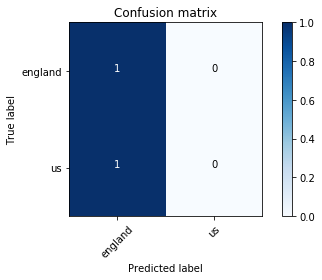

In [119]:
plot_confusion_matrix(cnf_mat, classes=labels)

In [217]:
print('True counts')
print(pd.Series(y_true_labels).value_counts())
print()
print('Pred counts')
pred_cnts = pd.Series(y_pred_labels).value_counts()
print(pred_cnts)
print()
print(f'Deviation from center: {abs(0.5 - pred_cnts[0]/len(y_pred))*200:.2f}%')

True counts
england    625
us         625
dtype: int64

Pred counts
england    1250
dtype: int64

Deviation from center: 100.00%


In [218]:
from sklearn import metrics
print(metrics.classification_report(y_true_labels, y_pred_labels))

             precision    recall  f1-score   support

    england       0.50      1.00      0.67       625
         us       0.00      0.00      0.00       625

avg / total       0.25      0.50      0.33      1250



/home/thibault/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Timer exploration

In [25]:
events = pd.DataFrame(t.events)[['Event', 'Relative', 'Absolute']]
events.head(10)

,Event,Relative,Absolute
0,Start,0.000000,0.000000
1,EPOCH 1,0.000436,0.000436
2,Start loop,1.494065,1.494501
3,Forward,0.075975,1.570476
4,Criterion,0.000332,1.570807
5,Backward,0.002446,1.573253
6,End loop,0.134512,1.707765
7,Start loop,0.003862,1.711627
8,Forward,0.065375,1.777002
9,Criterion,0.000079,1.777082


In [55]:
df = events.groupby('Event').sum().reset_index()[['Event', 'Relative']]
df

,Event,Relative
0,Backward,11.760916
1,Criterion,0.716652
2,END EPOCH 1,0.003843
3,END EPOCH 10,0.003312
4,END EPOCH 2,0.003597
5,END EPOCH 3,0.003425
6,END EPOCH 4,0.003970
7,END EPOCH 5,0.003595
8,END EPOCH 6,0.002521
9,END EPOCH 7,0.003401


In [108]:
dfs = []
df = None
for i, row in tqdm(events.iterrows(), total=len(events)):
    if ('EPOCH' in row.Event) and ('END' not in row.Event):
        if df is not None:
            dfs.append(pd.DataFrame(df))
        df = []
    if df is not None:
        df.append(row)
else:
    dfs.append(pd.DataFrame(df))

In [132]:
dfs_sum = []
for df in dfs:
    df = df.groupby('Event').sum().reset_index()
    epoch = df[df['Event'].apply(lambda e: ('EPOCH' in e) and ('END' not in e))].Event.iloc[0].split()[1]
    df = df[['Event', 'Relative']]
    df['epoch'] = epoch
    df = df[df['Event'].apply(lambda e: ('EPOCH' not in e) and ('reset' not in e))]
    dfs_sum.append(df)
df_sum = pd.concat(dfs_sum)

In [133]:
df_sum[df_sum['epoch'] == '1']

,Event,Relative,epoch
0,Backward,1.121399,1
1,Criterion,0.068291,1
4,End loop,121.760889,1
5,Forward,60.482495,1
6,Start loop,195.474357,1


In [137]:
def df_for(for_, df=df_sum):
    return df[df['Event'].apply(lambda e: for_ in e)]
df_for('Backward')

,Event,Relative,epoch
0,Backward,1.121399,1
0,Backward,1.168464,2
0,Backward,1.174321,3
0,Backward,1.165048,4
0,Backward,1.181437,5
0,Backward,1.186759,6
0,Backward,1.201952,7
0,Backward,1.186212,8
0,Backward,1.181523,9
0,Backward,1.193802,10


In [139]:
df_for('End')

,Event,Relative,epoch
4,End loop,121.760889,1
4,End loop,121.604301,2
4,End loop,121.476732,3
4,End loop,121.805236,4
4,End loop,121.570528,5
4,End loop,121.599942,6
4,End loop,120.969714,7
4,End loop,121.313114,8
4,End loop,122.150156,9
4,End loop,121.474665,10


In [140]:
df_for('Forward')

,Event,Relative,epoch
5,Forward,60.482495,1
5,Forward,61.910983,2
5,Forward,63.400217,3
5,Forward,63.693729,4
5,Forward,63.774350,5
5,Forward,63.623479,6
5,Forward,63.128641,7
5,Forward,63.479438,8
5,Forward,63.645172,9
5,Forward,63.313831,10


In [141]:
df_for('Start')

,Event,Relative,epoch
6,Start loop,195.474357,1
6,Start loop,1030.027789,2
6,Start loop,1365.159696,3
6,Start loop,1501.683723,4
6,Start loop,1531.223236,5
6,Start loop,1538.300006,6
6,Start loop,1522.411878,7
6,Start loop,1557.755526,8
6,Start loop,1554.391542,9
6,Start loop,1541.633949,10


In [138]:
df_for('Crit')

,Event,Relative,epoch
1,Criterion,0.068291,1
1,Criterion,0.070115,2
1,Criterion,0.071773,3
1,Criterion,0.072169,4
1,Criterion,0.071828,5
1,Criterion,0.072134,6
1,Criterion,0.071957,7
1,Criterion,0.074589,8
1,Criterion,0.071894,9
1,Criterion,0.071903,10


In [15]:
df_sum.groupby('Event').sum()

NameError: name 'df_sum' is not defined

## tmp

In [1]:
model

NameError: name 'model' is not defined

In [18]:
model.cuda()
out, output_sizes = model(inputs, input_sizes)

In [282]:
out

tensor([[-0.2268,  0.2268],
        [-0.5505,  0.5505]], device='cuda:0', grad_fn=<TransposeBackward0>)

In [281]:
with torch.no_grad():
    print(np.argmax(out, axis=1))

tensor([1, 1])


In [259]:
# import math
# from collections import OrderedDict

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.nn.parameter import Parameter
# from torch.autograd import Variable

# from models.modules import MaskConv, SequenceWise, BatchRNN, InferenceBatchSoftmax, \
#                     supported_rnns, supported_rnns_inv

# class AccentClassifier(nn.Module):
#     def __init__(self,
#                  labels,
#                  audio_conf={}, 
#                  rnn_hidden_size=800, 
#                  nb_layers=2, 
#                  rnn_type=nn.GRU):
        
#         super(AccentClassifier, self).__init__()

#         # metadata
#         self._audio_conf = audio_conf
#         self._labels = labels
#         self._num_classes = len(labels)
        
#         sample_rate = self._audio_conf.get("sample_rate", 16000)
#         window_size = self._audio_conf.get("window_size", 0.02)

#         self.conv = MaskConv(nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
#             nn.BatchNorm2d(32),
#             nn.Hardtanh(0, 20, inplace=True),
#             nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
#             nn.BatchNorm2d(32),
#             nn.Hardtanh(0, 20, inplace=True)
#         ))

#         # Based on above convolutions and spectrogram size using conv formula (W - F + 2P)/ S+1
#         rnn_input_size = int(math.floor((sample_rate * window_size) / 2) + 1)
#         rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1)
#         rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1)
#         rnn_input_size *= 32

#         rnns = []
#         rnn = BatchRNN(input_size=rnn_input_size, hidden_size=rnn_hidden_size, rnn_type=rnn_type,
#                        bidirectional=True, batch_norm=False)
#         rnns.append(('0', rnn))
#         for x in range(nb_layers - 1):
#             rnn = BatchRNN(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, rnn_type=rnn_type,
#                            bidirectional=True)
#             rnns.append(('%d' % (x + 1), rnn))
            
#         self.rnns = nn.Sequential(OrderedDict(rnns))

#         fully_connected = nn.Sequential(
#             nn.BatchNorm1d(rnn_hidden_size),
#             nn.Linear(rnn_hidden_size, self._num_classes, bias=False)
#         )
#         self.fc = nn.Sequential(
#             SequenceWise(fully_connected),
#         )
#         self.inference_softmax = InferenceBatchSoftmax()


#     def forward(self, x, lengths):
#         lengths = lengths.cpu().int()
#         output_lengths = self.get_seq_lens(lengths)
#         x, _ = self.conv(x, output_lengths)
#         sizes = x.size()
#         x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # Collapse feature dimension
#         x = x.transpose(1, 2).transpose(0, 1).contiguous()  # TxNxH

#         for rnn in self.rnns:
#             x = rnn(x, output_lengths)

#         x = self.fc(x)
#         x = x.transpose(0, 1)
#         # identity in training mode, softmax in eval mode
#         x = self.inference_softmax(x)
#         return x, output_lengths
    
#     def get_seq_lens(self, input_length):
#         """
#         Given a 1D Tensor or Variable containing integer sequence lengths, return a 1D tensor or variable
#         containing the size sequences that will be output by the network.
#         :param input_length: 1D Tensor
#         :return: 1D Tensor scaled by model
#         """
#         seq_len = input_length
#         for m in self.conv.modules():
#             if type(m) == nn.modules.conv.Conv2d:
#                 seq_len = ((seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) / m.stride[1] + 1)
#         return seq_len.int()

In [134]:
model

AccentClassifier(
  (conv): MaskConv(
    (seq_module): Sequential(
      (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Hardtanh(min_val=0, max_val=20, inplace)
      (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Hardtanh(min_val=0, max_val=20, inplace)
    )
  )
  (rnns): Sequential(
    (0): BatchRNN(
      (rnn): GRU(1312, 800, bidirectional=True)
    )
    (1): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (rnn): GRU(800, 800, bidirectional=True)
    )
  )
  (fc): Sequential(
    (0): SequenceWise (
    Sequential(
      (0): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=8

In [16]:
rnn = nn.GRU(10, 20, 2)
input_ = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input_, h0)

In [15]:
a = torch.randn(20, 32, 41, 563)
b = torch.randn(20, 32, 41, 420)

In [38]:
t = a.view(a.size(0), a.size(1) * a.size(2), a.size(3))
t = t.transpose(1, 2)
t2 = b.view(b.size(0), b.size(1) * b.size(2), b.size(3))
t2 = t2.transpose(1, 2)

rnn = nn.GRU(32 * 41, 256, 1)
output, hn = rnn(t2)

In [39]:
output.size()

torch.Size([20, 420, 256])

In [76]:
hn.size()

torch.Size([1, 420, 256])

In [83]:
output[:, -1].size()

torch.Size([20, 256])

In [55]:
t = torch.randn(20, 318, 1312)

In [68]:
p = nn.ConstantPad2d((0, 0, 2, 2), 0)

In [69]:
p(t).size()

torch.Size([20, 322, 1312])

In [ ]:
for module in self.seq_module:
    x = module(x)
    mask = torch.ByteTensor(x.size()).fill_(0)
    if x.is_cuda:
        mask = mask.cuda()
    for i, length in enumerate(lengths):
        length = length.item()
        if (mask[i].size(2) - length) > 0:
            mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)
    x = x.masked_fill(mask, 0)
return x, lengths


In [71]:
t.size()

torch.Size([20, 318, 1312])

In [99]:
t = torch.randn(20, 250, 1312)

clip = 300
if t.size(1) >= clip:
    t = t[:, :clip, :]
else:
    z = torch.zeros(torch.Size((t.size(0), clip - t.size(1), t.size(2))))
    z = z.cuda() if t.is_cuda else z
    t = torch.cat((t, z), 1)
    
t.size()

torch.Size([20, 300, 1312])

In [77]:
a = torch.tensor([1, 2, 4])
a.narrow()

tensor([2])

In [98]:
t = torch.randn(20, 250, 1312)
z = torch.zeros(torch.Size((t.size(0), clip - t.size(1), t.size(2))))
torch.cat((t, z), 1).size()

torch.Size([20, 300, 1312])

In [96]:
z

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 